**EDA on PUBG Data Set (HaAckathon)**

Data Set Background

In the PUBG game, there are up to 100 players in each game, and players can rank according to how many players are alive when they are eliminated. In the game, the player can pick up different weapons to attack the enemy, and can also recover teammates who were knocked down but not killed, drive a vehicle, swim, run, shoot, and bear the corresponding results-such as running too far or being enemy Kill. In order to win the game, you need to acquire weapons and available equipment to destroy others and survive to the end.

Aim 

In view of the previous statistics of players during each game and the ranking information in the data, we need to train the model to predict the ranking of the players in the test group based on the statistics during each game. The target tag position will be a percentage value between 0 and 1, with a higher percentage indicating a higher position in the match. In this process, we will analyze the impact of many factors on winning.

**import related libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Read the data set: (Save the data in the train variable)**

In [6]:
from google.colab import files
uploaded = files.upload()


Saving data.csv to data.csv


In [7]:
train = pd.read_csv('data.csv')

**View the variables contained in the data and the corresponding variable types**

We can get the variables in the data and the related variable content, which is convenient for subsequent analysis and operation.here is a very large data set.


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111742 entries, 0 to 1111741
Data columns (total 30 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Unnamed: 0       1111742 non-null  int64  
 1   Id               1111742 non-null  object 
 2   groupId          1111742 non-null  object 
 3   matchId          1111742 non-null  object 
 4   assists          1111742 non-null  int64  
 5   boosts           1111742 non-null  int64  
 6   damageDealt      1111742 non-null  float64
 7   DBNOs            1111742 non-null  int64  
 8   headshotKills    1111742 non-null  int64  
 9   heals            1111742 non-null  int64  
 10  killPlace        1111742 non-null  int64  
 11  killPoints       1111742 non-null  int64  
 12  kills            1111742 non-null  int64  
 13  killStreaks      1111742 non-null  int64  
 14  longestKill      1111742 non-null  float64
 15  matchDuration    1111742 non-null  int64  
 16  matchType        1

**We look at the first 10 sets of data:**

In [9]:
train.head(10)

,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,2093518,a3e3cea9f2e314,c9f6eaa81245b5,a3d8693390584c,0,0,25.93,0,0,0,84,1437,0,0,0.000,1403,squad-fpp,31,29,-1,0,0.0,0,0.0,0,0,151.30,1,1525,0.0667
1,3701672,43e4be7ad72cc7,521836de101ee8,b65de9055327e0,0,0,36.71,0,0,0,57,1225,0,0,0.000,1971,squad-fpp,30,30,-1,0,0.0,0,0.0,0,0,1918.00,7,1516,0.5862
2,2059784,9a68690e31fdff,4a72ffa2cebd90,d6aad3f9830e60,0,1,47.73,0,0,0,50,0,0,0,0.000,1741,solo-fpp,96,89,1516,0,4088.0,0,0.0,0,0,820.00,7,0,0.8105
3,1302036,b147e1bd448fc4,9a8991656b3fea,d931c0932d8aca,0,0,0.00,0,0,0,56,1286,0,0,0.000,1738,squad-fpp,28,27,-1,1,0.0,0,0.0,0,0,38.81,0,1515,0.5556
4,297180,d818b4edd59612,eece87c8b846b3,ec2b5ed94baae3,0,2,100.00,0,0,3,31,0,1,1,7.737,2193,solo,99,95,1482,0,918.4,0,0.0,0,0,1721.00,5,0,0.6429
5,2862125,e705cb7a4446ea,9d7180a567d020,b146588581df18,0,0,0.00,0,0,0,59,0,0,0,0.000,1358,solo-fpp,94,90,1503,0,0.0,0,0.0,0,0,446.00,3,0,0.4946
6,365937,e253262031e08f,e5df2dcdaf3f4b,c1385ae84655e6,0,0,0.00,0,0,0,81,0,0,0,0.000,1497,solo-fpp,99,98,1464,0,0.0,0,0.0,0,0,45.86,1,0,0.1939
7,3651102,c264a5ce0d4ca1,0efbbf391d7f62,b280791eb7a3fd,0,8,170.20,0,0,1,25,0,1,1,32.960,1968,solo-fpp,97,94,1544,0,0.0,0,221.0,0,0,3297.00,5,0,0.9688
8,2363197,342437cd2b5680,7acbacbed1b711,99cbf12f555f61,0,2,338.70,2,0,15,6,0,4,2,14.230,1989,duo,47,45,1492,1,3349.0,0,0.0,0,0,1846.00,5,0,0.7174
9,271498,3cf3cc81325a37,537c4bd393dcff,38a8b94623d77d,2,1,230.80,2,0,1,8,0,3,2,174.500,1373,squad-fpp,32,30,1449,0,0.0,0,0.0,0,0,3781.00,5,0,0.8387


I finished reading the data and have a rough understanding of the content of the data set and related details. Based on this, I will begin to process and analyze the data, and complete the requirements, we will gradually explore the data.

Here wI use some methods of big data processing, which effectively reduces the memory space occupied by data. The main idea is to change some data types that take up a lot of space to data types that take up less space without losing data. I will traverse sequentially, and finally reduce the memory by more than half. For example: For kills, it is found that its absolute value does not exceed 50, so the original int64 data type can be converted to int8, so that 1MB of data can be compressed to 0.125MB. Based on this idea, we have achieved effective compression of the data occupied space.

In [12]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

** Uni-Variate Analysis**

In the univariate analysis, based on our own game experience, we are more interested and consider the more important variables as the number of kills, the damage caused, the walking distance, the number of guns picked up by the player, and the number of Number of rescue items. We will conduct exploratory research on these variables in the data set to understand the distribution and characteristics of the variables. We believe that these factors have a greater impact on whether a game can achieve a higher ranking, we will verify this through correlation. 

1) We will calculate the number of kills in the data set and visually display it in the form of a tree diagram:

Here, because the overall distribution of the number of kills is scattered, we know from experience that the number of kills is generally small, so we use the mathematical method of quantiles to extract the data once, and the quantile we choose is 0.99, so as to ensure that almost all kills are included in it.

In [13]:
average_killers=train['kills'].mean() 

#most_killer_max represents the 0.99 quantile of the number of kills, which means that 99% of the data is less than this number
most_killer_max=train['kills'].quantile(0.99)

#max_killers represents the largest number of kills in the data (this data is due to our interest)
max_killers=train['kills'].max() 

#Output it
print("The average person kills {:.4f} players, 99% of people have {} kills or less, while the most kills ever recorded is {}.".format(average_killers,most_killer_max, max_killers))

The average person kills 0.9255 players, 99% of people have 7.0 kills or less, while the most kills ever recorded is 72.


That is, the 0.99 quantile is at 7, so we will ignore the part with the number of kills greater than 7 when drawing, because it is very few and not representative. If all the kills are paid attention to, it will lead to the graph. The image shift is serious and unnecessary.

We use a histogram to view the distribution of kills:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


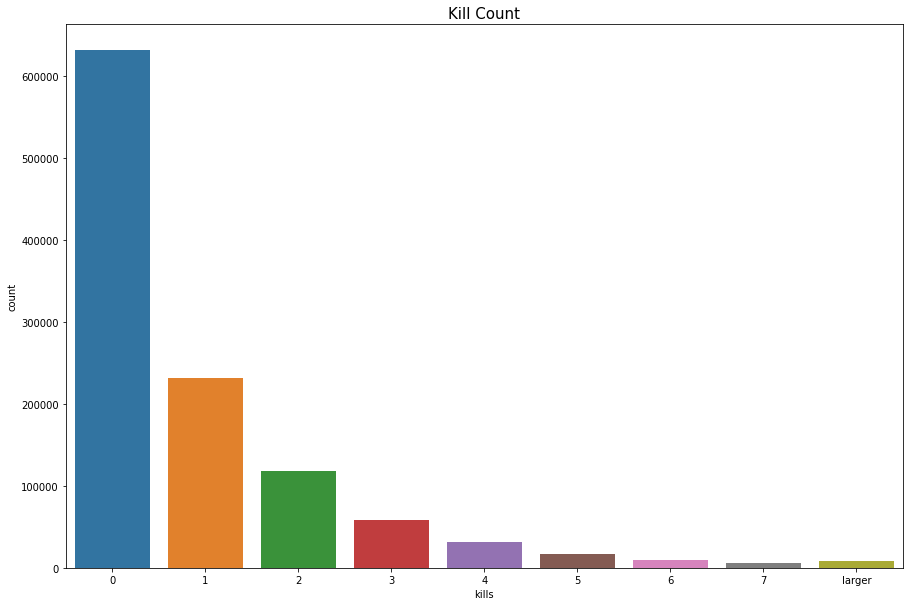

In [14]:
data = train.copy()  #data is a copy of train to avoid modifying the value of train
#The number of kills greater than 7 is attributed to larger
data.loc[data['kills'] > data['kills'].quantile(0.99)] = 'larger'
#Drawing, take kills as the abscissa, and the number of data as the ordinate
plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()


Obviously, we can see from this image that most people kill enemies at 0, some kill at 1 and 2, and very few can kill more enemies. This is also in line with our own gaming experience.

Since most people do not have the number of kills, we think it is necessary to analyze the amount of damage.

2) Damage

DamageDeal = total damage caused by the player - damage suffered by the player.

we will use a histogram to visually represent the data because damageDeal is a continuous quantity with scattered values

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


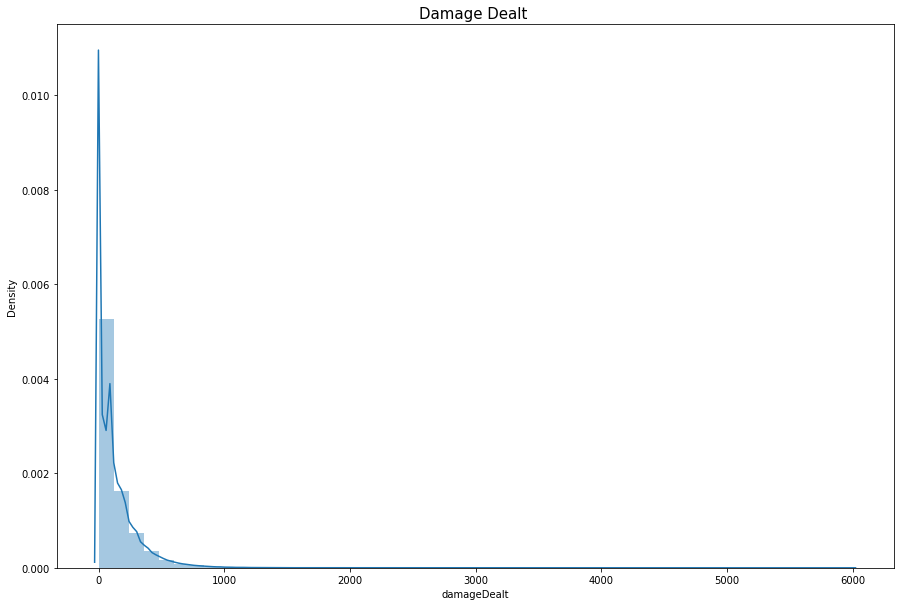

In [15]:
data = train.copy()  #data is a copy of train to avoid modifying the value of train
plt.figure(figsize=(15,10))
plt.title("Damage Dealt ",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

And damage caused by the player who killed 0 people:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


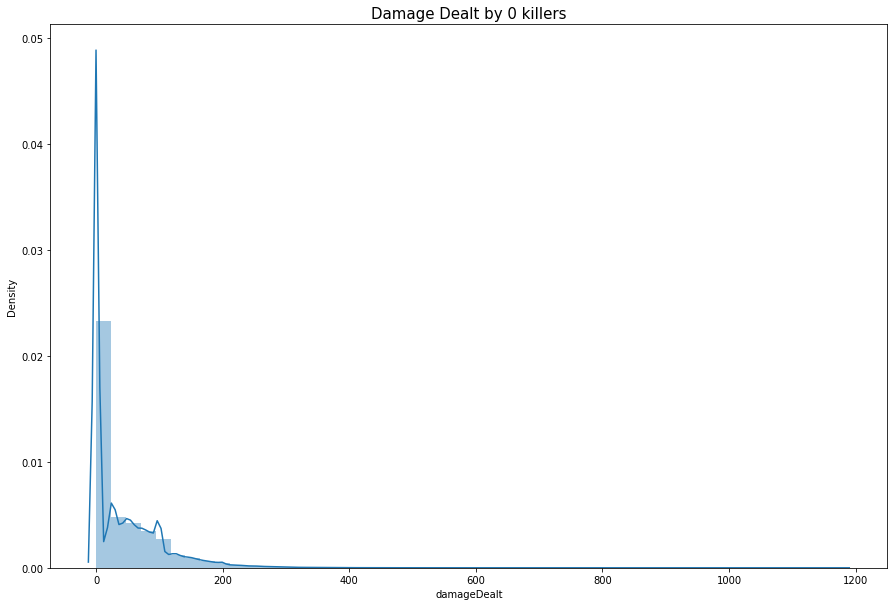

In [16]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,10))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

We plan to calculate the average damage of the final roaster for analysis, to show that the people with high damage have the greatest probability of roasting, but the value here is too large to be within an acceptable time We calculated, so we changed our minds. We looked at the probability that people with damage less than 0 and people with 0 kills could eat chickens, and inferred the close correlation between damage and kills and roasting.

##### no_kill_success_nums indicates the number of people who did not kill but succeeded in roasting

##### no_kill_success_rate indicates the probability of successfully roasting  without killing

##### no_damage_success_nums indicates the number of people who have 0 damage but succeeded in roasting

##### no_damage_success_rate indicates the probability of having 0 damage but successfully roasting

In [25]:

no_kill_success_nums=len(data[data['winPlacePerc']==1])

no_kill_success_rate=no_kill_success_nums/len(train)
#Output
print("{} players ({:.4f}%) have won without a single kill!".format(no_kill_success_nums,100*no_kill_success_rate))

data = train[train['damageDealt'] == 0].copy()

no_damage_success_nums=len(data[data['winPlacePerc']==1])

no_damage_success_rate = no_damage_success_nums/len(train)
#Output
print("{} players ({:.4f}%) have won without dealing damage!".format(no_damage_success_nums, 100*no_damage_success_rate))

1199 players (0.1078%) have won without a single kill!
1199 players (0.1078%) have won without dealing damage!


Therefore, it is obvious that the number of kills and the damage value are closely related. 


To draw a histogram of distances, first we preprocess the data to find the 0.99 quantile, so as to avoid some extremely small probability events that cause serious image shift

Walking distance refers to the distance the player walks. As the game progresses, the pubg game will gradually reduce the safety area, forcing the surviving players to move continuously. Generally speaking, the higher the player in a round, the greater the walking distance. Players with more distance tend to have a greater probability of completing the chicken, and we will use data to illustrate this point. We will compare the walk in the data


In [26]:
print ("The average walking distance is: {:.0f}".format(train['walkDistance'].mean()))
print ("99% of walking distances are less than this value:",train['walkDistance'].quantile(0.99))
print ("The largest walking distance in the dataset:",train['walkDistance'].max())

The average walking distance is: 1153
99% of walking distances are less than this value: 4393.0
The largest walking distance in the dataset: 13960.0


**According to the result, we draw a histogram:**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


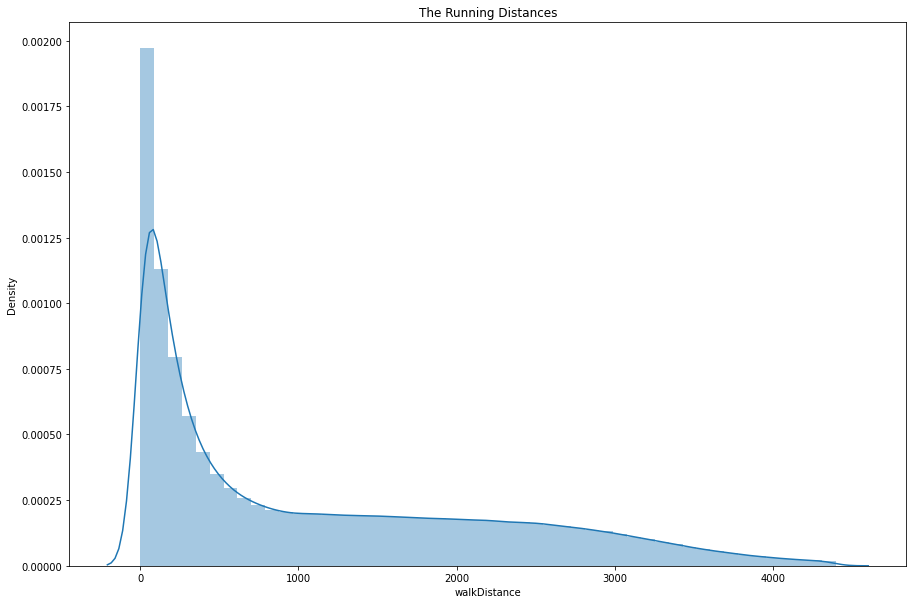

In [27]:
data = train[train['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("The Running Distances")
sns.distplot(data['walkDistance'])   #distplot histogram
plt.show()

Here we check the walking distance of the final winner:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


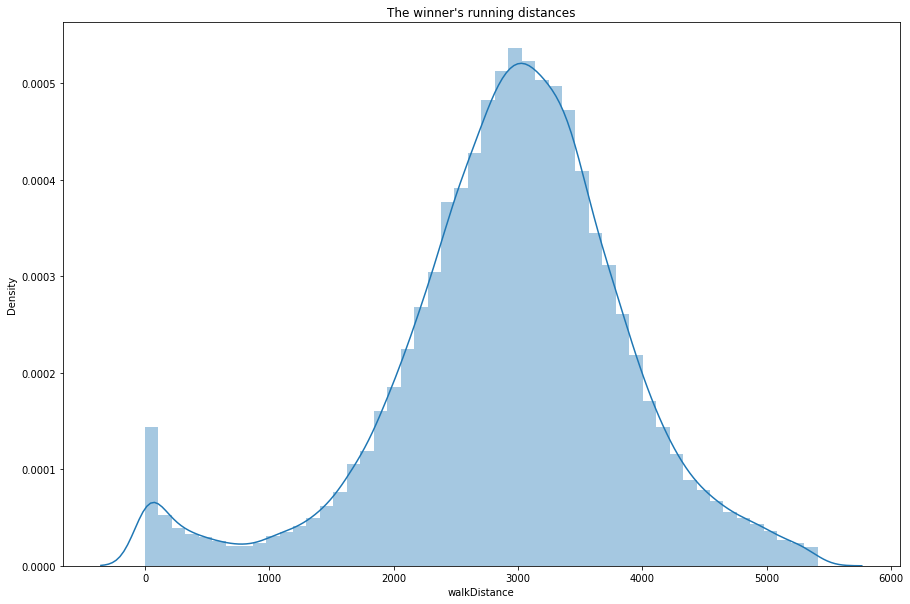

In [28]:
winner_data=train[train['winPlacePerc'] == 1].copy()
winner_data = winner_data[winner_data['walkDistance'] < winner_data['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("The winner's running distances")
sns.distplot(winner_data['walkDistance'])   #distplot histogram
plt.show()

**we know that the final winner usually walks around 3000m, which is a higher walking distance.**

** Guns picked up by players**
Since having more ammunition supplies and weapon supplies will have a very big advantage, in addition, after killing the enemy, the player is likely to find new weapons, so the number of guns is also very important, so we will check the number of guns for the player Simple Analysis. 

In [29]:
print ("The average number of guns picked up is: {:.0f}".format(train['weaponsAcquired'].mean()))
print ("0.99 quantile of the number of guns picked up:",train['weaponsAcquired'].quantile(0.99))
print ("The largest number of guns picked up in the data set:",train['weaponsAcquired'].max())

The average number of guns picked up is: 4
0.99 quantile of the number of guns picked up: 10.0
The largest number of guns picked up in the data set: 177


So we draw a graph based results to visually show the specific situation:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


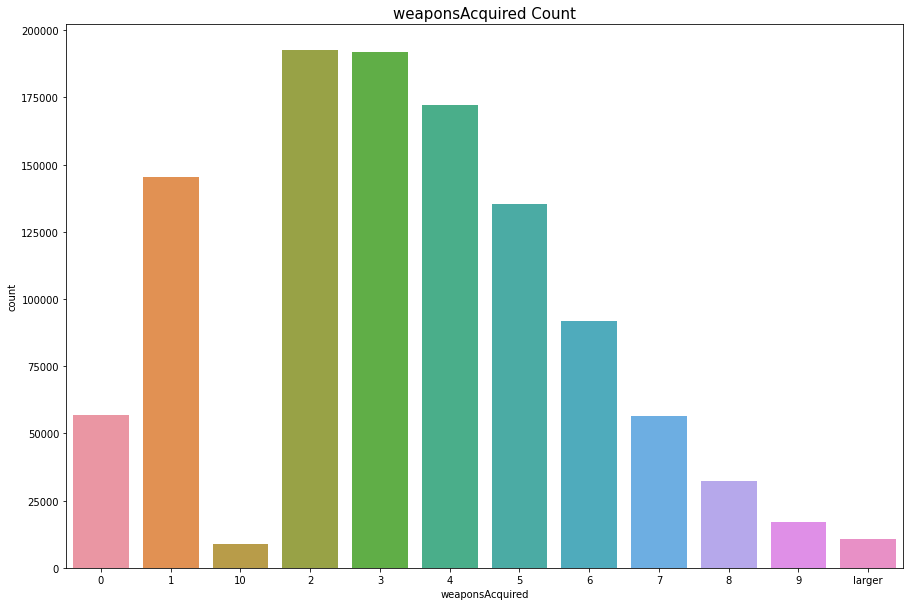

In [30]:
data = train.copy()  #data is a copy of train to avoid modifying the value of train
#The number of kills greater than 7 is attributed to larger
data.loc[data['weaponsAcquired'] > data['weaponsAcquired'].quantile(0.99)] = 'larger'
#Drawing, take kills as the abscissa, and the number of data as the ordinate
plt.figure(figsize=(15,10))
sns.countplot(data['weaponsAcquired'].astype('str').sort_values())
plt.title("weaponsAcquired Count",fontsize=15)
plt.show()

Form the above graph we easily observed that most player get 1~4 weapons per round.

** Heals and Boost are very important in the game so we will conduct preliminary data analysis on them. We will first look at some basic data:**

In [31]:
average_heals=train['heals'].mean()
quantile_099_heals=train['heals'].quantile(0.99)
print("The average number of therapeutic materials used per person is: {:.1f}, 99% of people use less than:.{}".format(average_heals, quantile_099_heals))
average_boosts=train['boosts'].mean()
quantile_099_boosts=train['boosts'].quantile(0.99)
print("The average number of supplementary materials used per person is: {:.1f}, 99% of the people use less than:.{}".format(average_boosts, quantile_099_boosts))

The average number of therapeutic materials used per person is: 1.4, 99% of people use less than:.12.0
The average number of supplementary materials used per person is: 1.1, 99% of the people use less than:.7.0


**Relation between Variables **

We will use the univariate data analysis in the previous stage to conduct an in-depth study here, which will give us a clearer understanding of the final winning factors. At this stage, we will analyze in detail the influence of various factors on whether to eat chicken and the specific ranking. 

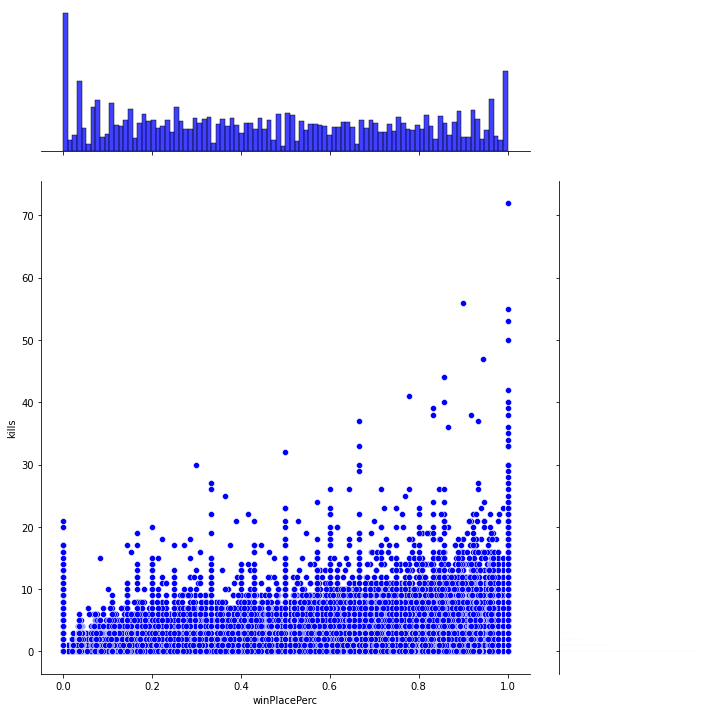

In [32]:
# Kills 
sns.jointplot(x="winPlacePerc", y="kills", data=train, height=10, ratio=3, color="blue")
plt.show()

In order to illustrate more precisly, we also try to plot box plot:

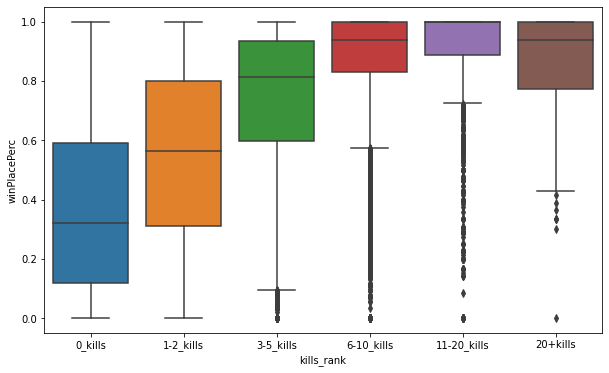

In [33]:
train['kills_rank'] = pd.cut(train['kills'], [-1, 0, 2, 5, 10, 20, 60] ,labels = ['0_kills', '1-2_kills', '3-5_kills', '6-10_kills', '11-20_kills', '20+kills'])
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'kills_rank', y = 'winPlacePerc', data = train)
plt.show()

From the above box plot we observe that Players with higher rankings usually have a higher kill count, and the final player who roasting usually kills more than 5 enemies.

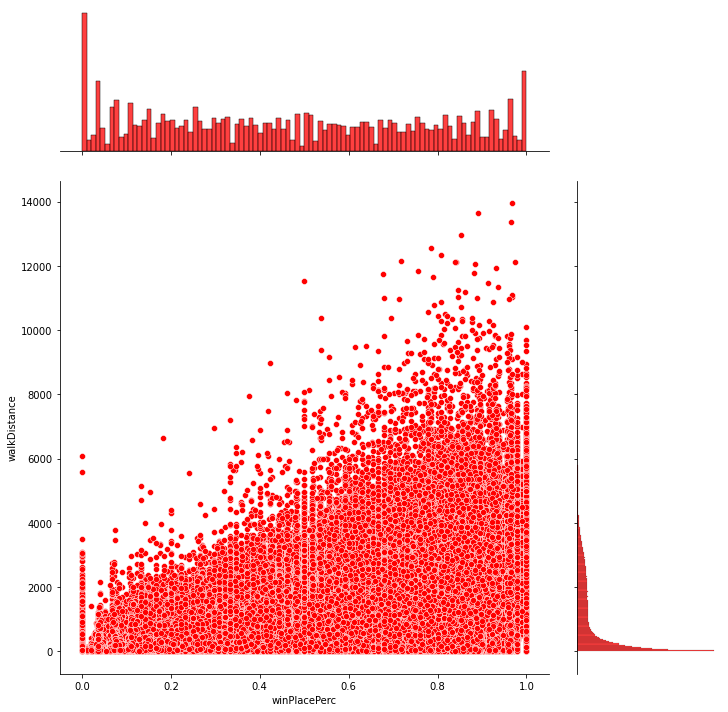

In [35]:
# Walking Distance 
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, height=10, ratio=3, color="red")
plt.show()

** Walking distance has a higher correlation with ranking.**

**Heals and Boosts** 

We will deeply analyze the relationship between heals and boosts. We draw the two together:

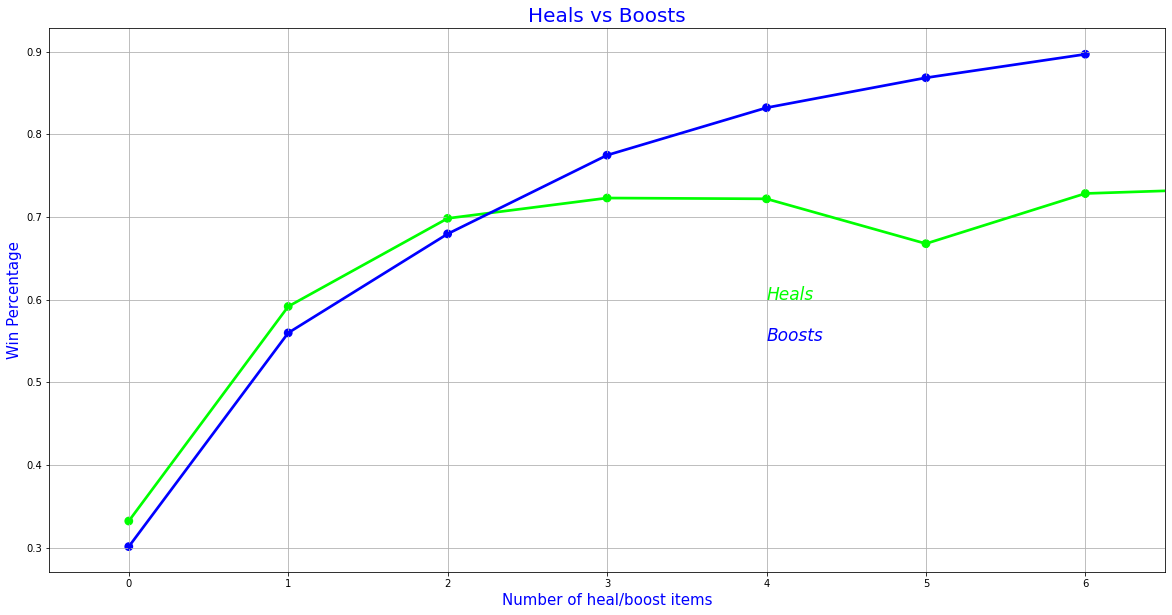

In [36]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 17,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

From the above graph We have analyzed that heals and boosts are positively corelated to each other that is, players who can eventually roasting usually have more gaining and therapeutic items to use. We will use a scatter diagram to depict this relationship and further analyze:

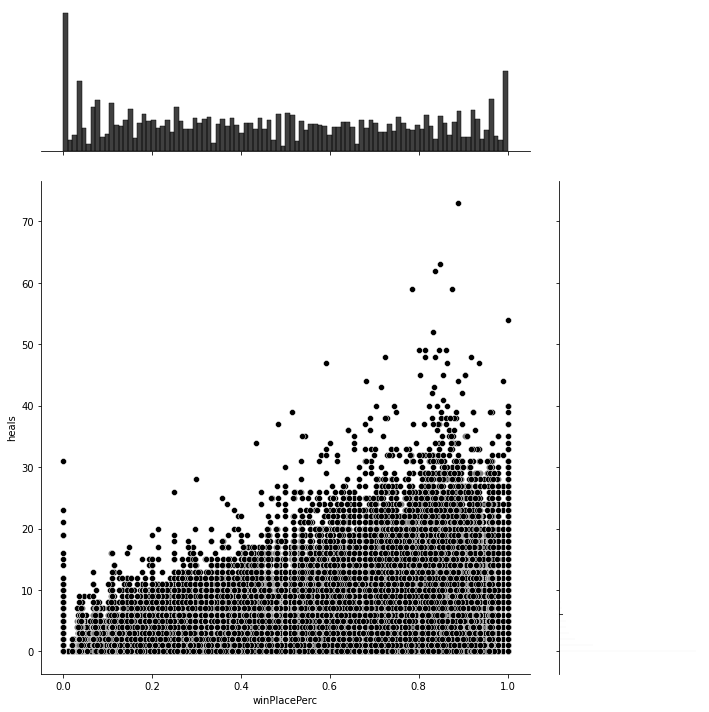

In [37]:
sns.jointplot(x="winPlacePerc", y="heals", data=train, height=10, ratio=3, color="black")
plt.show()

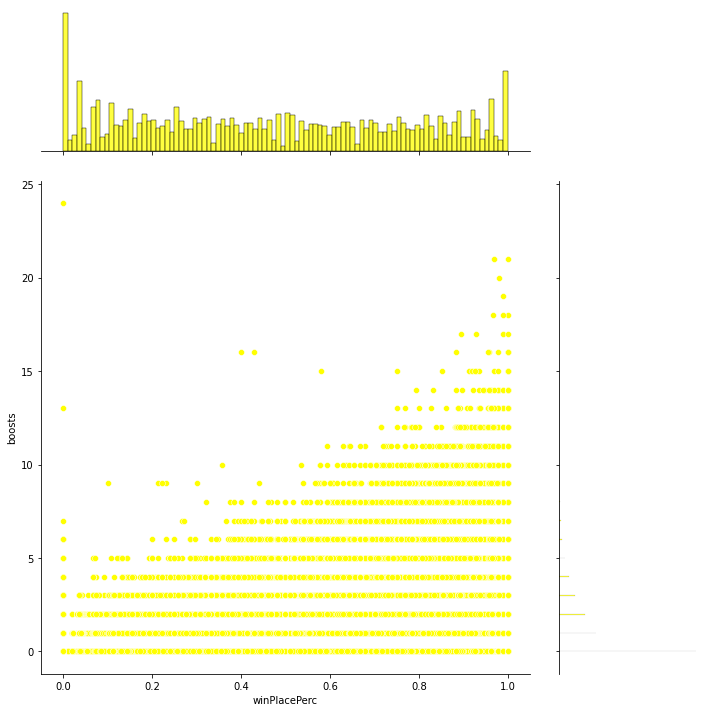

In [38]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, height=10, ratio=3, color="yellow")
plt.show()

From the above graph we observe that players with higher rankings usually have more boosts items in the game. So we conclude that players who get more heals and boosts items can get a better ranking but there are some abnormal values.

### Solo, Duos and Quads kills

The game has three matching methods, namely solo, duos, squads and custom because their is no guarantee 100 players per match, nor at most 4 players per group.So we believe that if there are more than 50 teams in a game, it means It is a single row, there are 25-50 teams, it means that it is a double row, there are less than 25 teams, it means that it is a four-row. We will count the data set and calculate the number of matches with different matching modes:

In [39]:
solos = train[train['numGroups']>50]
duos = train[(train['numGroups']>25) & (train['numGroups']<=50)]
squads = train[train['numGroups']<=25]
print("Number and proportion of single-row games: {} ({:.2f}%); Number and proportion of double-row games: {} ({:.2f}%); Number and proportion of four-row games: () ( {:.2f}%) ".format(len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train),))

Number and proportion of single-row games: 177161 (15.94%); Number and proportion of double-row games: 824015 (74.12%); Number and proportion of four-row games: () ( 110566.00%) 


Here we will analyze the impact of the number of kills on the final ranking under different matching modes. We will plot the data under the three modes and compare them and classify the data set according to the matching mode, and plot the number of kills and rankings in each category. 

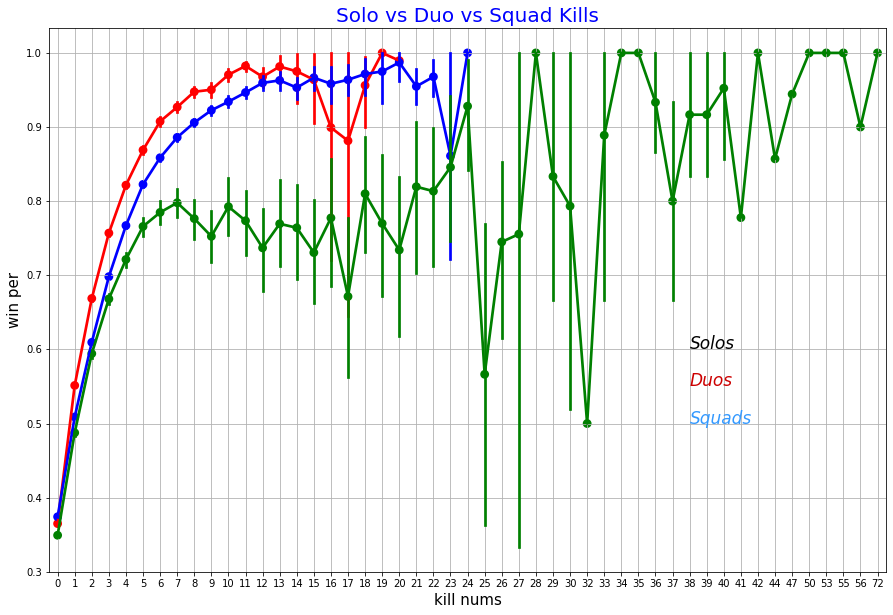

In [40]:
f,ax1 = plt.subplots(figsize =(15,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='red',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='blue',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='green',alpha=0.8)
plt.text(37,0.6,'Solos',color='black',fontsize = 17,style = 'italic')
plt.text(37,0.55,'Duos',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(37,0.5,'Squads',color='#3399FF',fontsize = 17,style = 'italic')
plt.xlabel('kill nums',fontsize = 15,color='black')
plt.ylabel('win per',fontsize = 15,color='black')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

From the above graph we observe that number of kills and wins in single and double rows are basically the same, that is, teams with more kills are more likely to win, and the probability of winning increases with the number of kills. The number of growth has increased significantly. But in the fourth row, it is different from the previous two. When the number of kills is less than about 10, the correlation is more obvious; but when the number of kills is more than 10, the probability of winning is positively correlated with the number of kills. Relationship, but the growth is very slow and less obvious.** This is an interesting.**

We believe that the main reason for this interesting fact that teammates are likely to rescue/raise after knocking down the enemy in the fourth row. So we consider the number of enemies knocked down and the number of teammates rescued by different teams.

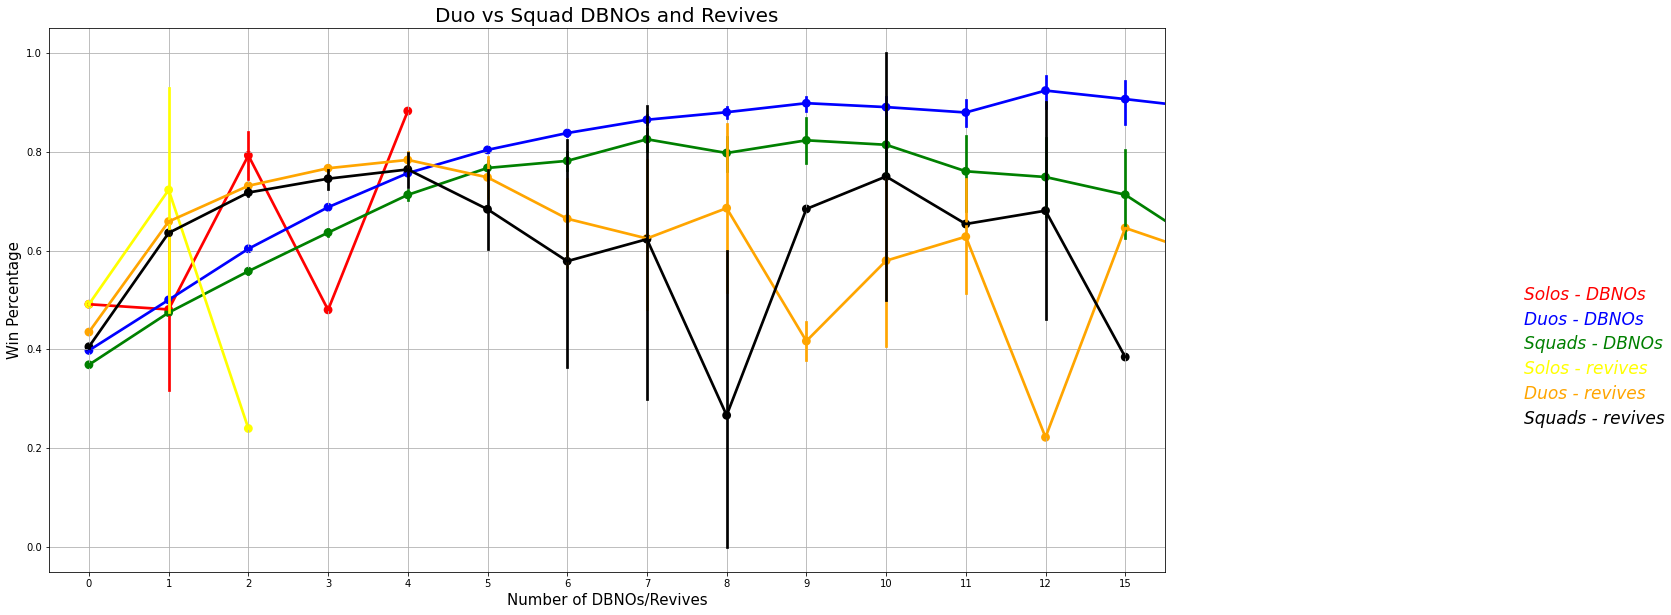

In [41]:
f,ax1 = plt.subplots(figsize =(20,10))
#The number of enemies knocked down and the probability of winning in different modes
sns.pointplot(x='DBNOs',y='winPlacePerc',data=solos,color='red',alpha=0.8)
sns.pointplot(x='DBNOs',y='winPlacePerc',data=duos,color='blue',alpha=0.8)
sns.pointplot(x='DBNOs',y='winPlacePerc',data=squads,color='green',alpha=0.8)
#The number of rescue teammates and the probability of winning in different modes
sns.pointplot(x='revives',y='winPlacePerc',data=solos,color='yellow',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=duos,color='orange',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=squads,color='black',alpha=0.8)
#mark
plt.text(18,0.5,'Solos - DBNOs',color='red',fontsize = 17,style = 'italic')
plt.text(18,0.45,'Duos - DBNOs',color='blue',fontsize = 17,style = 'italic')
plt.text(18,0.4,'Squads - DBNOs',color='green',fontsize = 17,style = 'italic')

plt.text(18,0.35,'Solos - revives',color='yellow',fontsize = 17,style = 'italic')
plt.text(18,0.3,'Duos - revives',color='orange',fontsize = 17,style = 'italic')
plt.text(18,0.25,'Squads - revives',color='black',fontsize = 17,style = 'italic')

plt.xlabel('Number of DBNOs/Revives',fontsize = 15,color='black')
plt.ylabel('Win Percentage',fontsize = 15,color='black')
plt.title('Duo vs Squad DBNOs and Revives',fontsize = 20,color='black')
plt.grid()
plt.show()

Analysis: Overall, in the solo and duos modes, the probability of winning increases with the increase of DBNOs; but in the squads mode, the increase is more obvious when the DBNOs is small, but when the DBNOs is greater than 6, the increase will no longer be obvious. Very gentle. The number of rescues is more interesting. Usually, teams with a higher number of rescues will have a lower probability of winning. That is, the probability of winning increases first and then decreases with the increase of the number of rescues. This phenomenon is especially obvious for the squads mode.

**Multivariate Analysis **

There are many variables which are correlated, so we check it by drawing a variable heat diagram. The heatmap can use color changes to reflect the data information in a two-dimensional matrix or table, and it can intuitively express the size of the data value in a defined color depth. The data is clustered as needed, and the clustered data is displayed on the heatmap, and the similarity and difference of the data are reflected by the color gradient and similarity. We draw a heatmap on the train data to reflect the comprehensive relationship. 

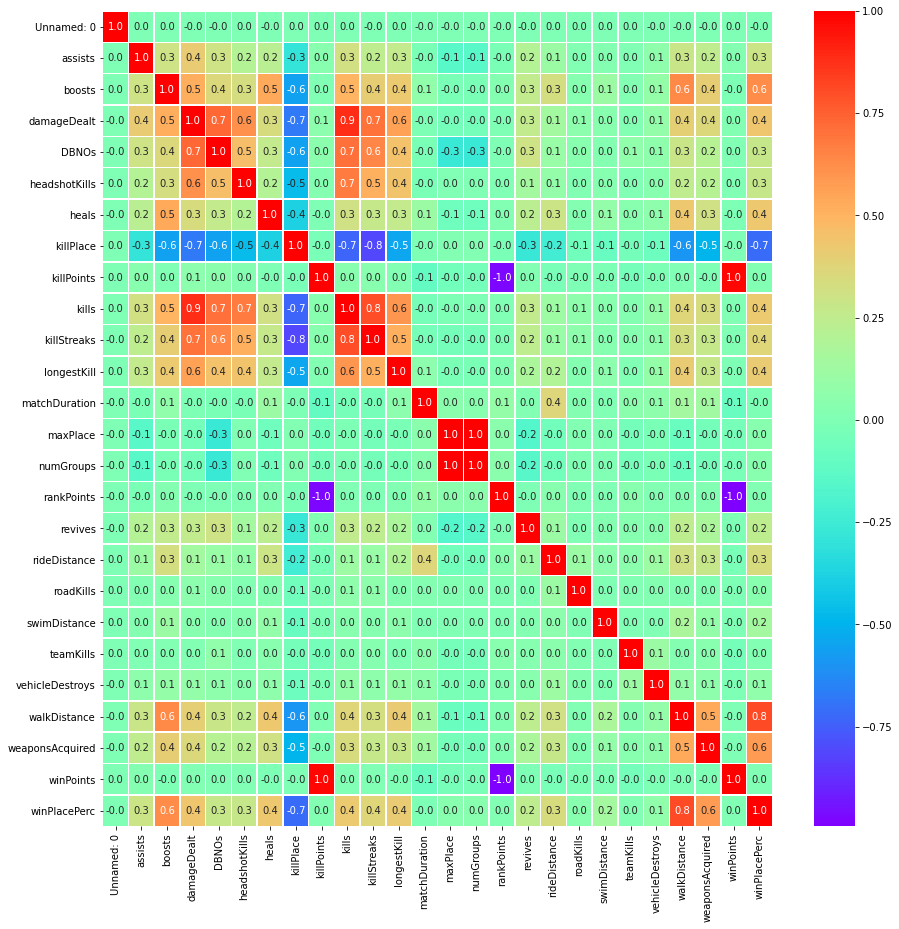

In [42]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax,cmap='rainbow')
plt.show()

From the above heat map we conclude that walking distance has positive coraltion on winPlacePerc and killPlace has the greatest negative correlation effect. 

There are 8 variables in total, namely boosts, damageDealt, heals, kills, killStreaks, longestkill, walkDistance, and weaponsAcquired. Let's make a heat map for the 8 variables:

In [47]:
import seaborn as sns 
k = 8 #Variable number
f,ax = plt.subplots(figsize=(11, 11))
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values，cmap='rainbow')
plt.show()

SyntaxError: ignored

The specific correlation between these variables, we use the pairplot method to plot:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


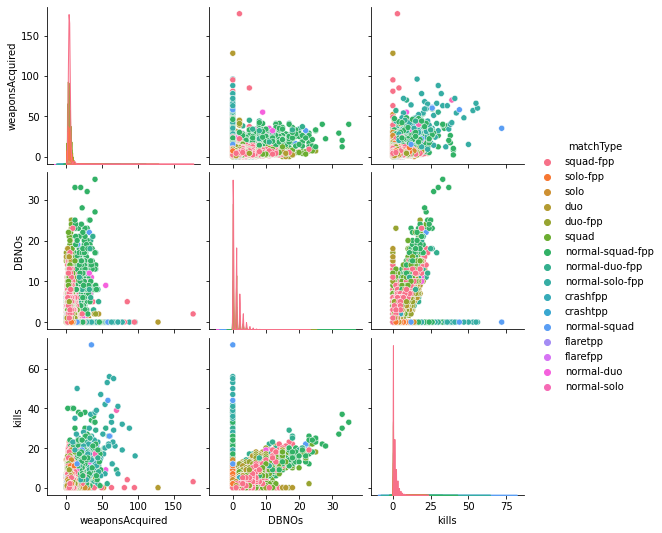

In [48]:
data = train.loc[:,['weaponsAcquired','DBNOs','kills','matchType']]
sns.pairplot(data,hue='matchType')

Through these scatter plot matrices, we can see the specific relationship between these variables. The scatter plot matrix is ​​a great tool for identifying and analyzing trends. 

**Model ** 

We implement some preparatory works before building a specific model, including reading related data, classifying related data, reading some important information, and establishing basic functional functions

In [54]:
def BuildFeature(is_train=True):
    
    y = None
    test_idx = None
    
    if is_train: 
        print("Reading train.csv")
        df = pd.read_csv('train.csv')           
        df = df[df['maxPlace'] > 1]
    else:
        print("Reading test.csv")
        df = pd.read_csv('test.csv')
        test_idx = df.Id
    
    # Reduce the memory usage
    df = reduce_mem_usage(df)
    
    print("Delete Unuseful Columns")
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchType")  
    
    if is_train: 
        print("Read Labels")
        y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
        features.remove(target)

    print("Read Group mean features")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    if is_train:
        df_out = agg.reset_index()[['matchId','groupId']]
    else:
        df_out = df[['matchId','groupId']]
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])

    print("Read Group max features")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("Read Group min features")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("Read Group size features")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("Read Match mean features")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    print("Read Match size features")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)
    X = df_out
    feature_names = list(df_out.columns)
    del df, df_out, agg, agg_rank
    gc.collect()

    return X, y, feature_names, test_idx

In [55]:
# Access related train and test data models:

X_train, y_train, train_columns, _ = BuildFeature(is_train=True)
X_test, _, _ , test_idx = BuildFeature(is_train=False)

Reading train.csv


FileNotFoundError: ignored

In [ ]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression(n_jobs=4, normalize=True)
LR_model.fit(X_train,y_train)

In [ ]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=True)

In [ ]:
LR_model.score(X_train,y_train)

In [ ]:
# We visualized the prediction results of the test set here:

y_pred_train = LR_model.predict(X_train)
y_pred_test = LR_model.predict(X_test)

y_pred_train[y_pred_train>1] = 1
y_pred_train[y_pred_train<0] = 0

f, ax = plt.subplots(figsize=(10,10))
plt.scatter(y_train, y_pred_train)
plt.xlabel("y")
plt.ylabel("y_pred_train")
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()